In [1]:
# Global
import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Local
import examples_utils as eu
import fastPTA.utils as ut
import fastPTA.plotting_functions as pf
from fastPTA.signals import SMBBH_parameters
from fastPTA.Fisher_code import compute_fisher

In [2]:
def T_scaling(
    rerun=False,
    T_min_yrs=0.1,
    T_max_yrs=100,
    N_times=10,
    N_runs=20,
    n_pulsars=30,
    signal_label="power_law",
    signal_parameters=SMBBH_parameters,
    order=0,
    method="Legendre",
    add_curn=True,
    default_pulsars=eu.EPTAlike,
    add_HD_prior=True,
    signal_labels=[r"$\alpha_{*}$", r"$n_{\rm T}$"],
    save_path="Default",
):
    # test evolution of SNR with T_obs
    parameter_len = (
        len(signal_parameters) + order + 1 if order else len(signal_parameters)
    )

    get_tensors_kwargs = {
        "add_curn": add_curn,
        "order": order,
        "method": method,
        "regenerate_catalog": True,
    }

    if save_path != "Default":
        pass
    elif order == 0:
        save_path = "generated_data/T_scaling.npz"
    else:
        save_path = "generated_data/T_scaling_HD.npz"

    try:
        if rerun:
            raise FileNotFoundError("Forcing regeneration")

        data = np.load(save_path)

        T_obs_values = data["T_obs_values"]
        SNR_mean = data["SNR_mean"]
        SNR_std = data["SNR_std"]

        parameters_mean = data["parameters_mean"]
        parameters_std = data["parameters_std"]

    except FileNotFoundError:
        T_obs_values = np.geomspace(T_min_yrs, T_max_yrs, N_times)
        SNR_mean = np.zeros(shape=(N_times,))
        SNR_std = np.zeros(shape=(N_times,))
        parameters_mean = np.zeros(shape=(N_times, parameter_len))
        parameters_std = np.zeros(shape=(N_times, parameter_len))

        for i in range(N_times):
            SNR_iteration = np.zeros(shape=(N_runs,))
            parameters_iteration = np.zeros(shape=(N_runs, parameter_len))

            generate_catalog_kwargs = default_pulsars.copy()
            generate_catalog_kwargs["n_pulsars"] = n_pulsars
            generate_catalog_kwargs["T_span_dict"] = {
                "which_distribution": "gaussian",
                "mean": np.log10(T_obs_values[i]),
                "std": 0.0125,
            }

            print(
                "Here starts T = %.2f yrs (iteration %d of %d)"
                % (T_obs_values[i], i + 1, N_times)
            )

            for j in tqdm.tqdm(range(N_runs)):
                (
                    frequency,
                    signal,
                    HD_functions_IJ,
                    HD_coeffs,
                    effective_noise,
                    SNR,
                    fisher,
                ) = compute_fisher(
                    T_obs_yrs=T_obs_values[i],
                    n_frequencies=30 + int(T_obs_values[i]),
                    signal_label=signal_label,
                    signal_parameters=signal_parameters,
                    get_tensors_kwargs=get_tensors_kwargs,
                    generate_catalog_kwargs=generate_catalog_kwargs,
                )

                if order and add_HD_prior:
                    fisher += np.diag(
                        np.append(np.zeros(len(signal_parameters)), np.ones(order + 1))
                    )
                c_inverse = ut.compute_inverse(fisher)
                errors = np.sqrt(np.diag(c_inverse))

                SNR_iteration[j] = SNR
                parameters_iteration[j] = errors

            SNR_mean[i] = np.mean(SNR_iteration, axis=0)
            SNR_std[i] = np.std(SNR_iteration, axis=0)

            parameters_mean[i] = np.mean(parameters_iteration, axis=0)
            parameters_std[i] = np.std(parameters_iteration, axis=0)

            print("SNR=%.2e +-%.2e \n" % (SNR_mean[i], SNR_std[i]))

        to_save = {
            "T_obs_values": T_obs_values,
            "SNR_mean": SNR_mean,
            "SNR_std": SNR_std,
            "parameters_mean": parameters_mean,
            "parameters_std": parameters_std,
        }

        np.savez(save_path, **to_save)

    # here plot scaling of SNR with T_obs
    plt.figure(figsize=(6, 4))
    plt.errorbar(
        T_obs_values,
        SNR_mean,
        yerr=SNR_std,
        color=pf.my_colormap["cyan"],
        fmt="o",
        markersize=4,
        linestyle="dashed",
        capsize=7,
    )

    # plot x**3
    plt.loglog(T_obs_values, 0.1 * T_obs_values**3, linestyle="--", color="black")
    plt.text(1, 5e-3, s=r"$\propto T^3$", fontsize=15)

    # plot x**(1/2)
    plt.loglog(T_obs_values, 2 * T_obs_values**0.5, linestyle="--", color="black")
    plt.text(30, 1.5, s=r"$\propto \sqrt{T}$", fontsize=15)

    plt.xlabel(r"$T_{\rm obs} \rm [yr]$")
    plt.ylabel(r"$\rm SNR$")
    plt.ylim(5e-6, 50)
    plt.tight_layout()
    plt.savefig("plots/SNR_T_scaling.pdf")

    plt.figure(figsize=(6, 4))
    for i in range(len(signal_parameters)):
        colors = list(pf.my_colormap.keys())
        col = colors[np.mod(i, len(colors))]
        plt.errorbar(
            T_obs_values,
            parameters_mean[:, i],
            yerr=parameters_std[:, i],
            color=col,
            fmt="o",
            markersize=4,
            linestyle="dashed",
            capsize=7,
            label=signal_labels[i],
        )

    plt.loglog(
        T_obs_values,
        100 / T_obs_values**3,
        linestyle="--",
        color="black",
    )

    plt.text(0.5, 1e4, s=r"$\propto 1/T^3$", fontsize=15)

    plt.loglog(
        T_obs_values,
        0.6 / T_obs_values ** (1 / 2),
        linestyle="--",
        color="black",
    )

    plt.text(30, 1, s=r"$\propto 1/\sqrt{T}$", fontsize=15)

    plt.xlabel(r"$T_{\rm obs} \rm [yr]$")
    plt.ylabel(r"$\rm Uncertainties$")
    plt.ylim(1e-2, 1e6)
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.savefig("plots/Error_T_scaling.pdf")

    if order:
        if method == "Legendre":
            label = r"$\rm Polynomial \ \ell = \ $"
        else:
            label = r"$\rm Bin \ = \ $"
        # here plot scaling of SNR with T_obs
        plt.figure(figsize=(6, 4))
        for i in range(order + 1):
            plt.errorbar(
                T_obs_values,
                parameters_mean[:, len(signal_parameters) + i],
                yerr=parameters_std[:, len(signal_parameters) + i],
                label=label + str(i),
                color=pf.cmap_HD(0.1 + i / 1.1 / (order + 1)),
            )

        plt.xlabel(r"$T_{\rm obs} \rm [yr]$")
        plt.ylabel(r"$\rm Uncertainties$")
        plt.ylim(1e-2, 1e5)
        plt.xscale("log")
        plt.yscale("log")
        plt.legend(fontsize=12, ncols=2)
        plt.tight_layout()
        plt.savefig("plots/SNR_T_scaling_HD.pdf")


def N_scaling(
    rerun=False,
    N_min=5,
    N_max=200,
    N_times=20,
    N_runs=20,
    signal_label="power_law",
    signal_parameters=SMBBH_parameters,
    order=0,
    method="Legendre",
    add_curn=True,
    default_pulsars=eu.EPTAlike,
    add_HD_prior=True,
    signal_labels=[r"$\alpha_{*}$", r"$n_{\rm T}$"],
    save_path="Default",
):
    # test evolution of SNR with T_obs
    parameter_len = (
        len(signal_parameters) + order + 1 if order else len(signal_parameters)
    )

    get_tensors_kwargs = {
        "add_curn": add_curn,
        "order": order,
        "method": method,
        "regenerate_catalog": True,
    }

    if save_path != "Default":
        pass
    elif order == 0:
        save_path = "generated_data/N_scaling.npz"
    else:
        save_path = "generated_data/N_scaling_HD.npz"

    try:
        if rerun:
            raise FileNotFoundError("Forcing regeneration")

        data = np.load(save_path)

        N_pulsars = data["N_pulsars"]
        SNR_mean = data["SNR_mean"]
        SNR_std = data["SNR_std"]

        parameters_mean = data["parameters_mean"]
        parameters_std = data["parameters_std"]

    except FileNotFoundError:
        N_pulsars = np.unique(np.geomspace(N_min, N_max, N_times, dtype=int))
        N_times = len(N_pulsars)
        SNR_mean = np.zeros(shape=(N_times,))
        SNR_std = np.zeros(shape=(N_times,))
        parameters_mean = np.zeros(shape=(N_times, parameter_len))
        parameters_std = np.zeros(shape=(N_times, parameter_len))

        for i in range(N_times):
            SNR_iteration = np.zeros(shape=(N_runs,))
            parameters_iteration = np.zeros(shape=(N_runs, parameter_len))

            generate_catalog_kwargs = default_pulsars.copy()
            generate_catalog_kwargs["n_pulsars"] = N_pulsars[i]

            print("Here starts N = %d" % (N_pulsars[i]))
            for j in tqdm.tqdm(range(N_runs)):
                (
                    frequency,
                    signal,
                    HD_functions_IJ,
                    HD_coeffs,
                    effective_noise,
                    SNR,
                    fisher,
                ) = compute_fisher(
                    n_frequencies=30,
                    signal_label=signal_label,
                    signal_parameters=signal_parameters,
                    get_tensors_kwargs=get_tensors_kwargs,
                    generate_catalog_kwargs=generate_catalog_kwargs,
                )

                if order and add_HD_prior:
                    fisher += np.diag(
                        np.append(np.zeros(len(signal_parameters)), np.ones(order + 1))
                    )

                c_inverse = ut.compute_inverse(fisher)
                errors = np.sqrt(np.diag(c_inverse))

                SNR_iteration[j] = SNR
                parameters_iteration[j] = errors

            SNR_mean[i] = np.mean(SNR_iteration, axis=0)
            SNR_std[i] = np.std(SNR_iteration, axis=0)

            parameters_mean[i] = np.mean(parameters_iteration, axis=0)
            parameters_std[i] = np.std(parameters_iteration, axis=0)

            print("SNR=%.2e +-%.2e \n" % (SNR_mean[i], SNR_std[i]))

        to_save = {
            "N_pulsars": N_pulsars,
            "SNR_mean": SNR_mean,
            "SNR_std": SNR_std,
            "parameters_mean": parameters_mean,
            "parameters_std": parameters_std,
        }

        np.savez(save_path, **to_save)

    # here plot scaling of SNR with N_pulsars
    plt.figure(figsize=(6, 4))

    plt.errorbar(
        N_pulsars,
        SNR_mean,
        yerr=SNR_std,
        color=pf.my_colormap["cyan"],
        fmt="o",
        markersize=4,
        linestyle="dashed",
        capsize=7,
    )

    plt.loglog(
        N_pulsars,
        np.sqrt(N_pulsars) / 2,
        linestyle="--",
        color="black",
    )

    plt.text(2e1, 7, s=r"$\propto \sqrt{N_{\rm pulsars}}$", fontsize=15)
    plt.ylim(0.5, 2e1)
    plt.xlabel(r"$N_{\rm pulsars}$", fontsize=20)
    plt.ylabel(r"$\rm SNR$", fontsize=20)
    plt.tight_layout()
    plt.savefig("plots/SNR_N_scaling.pdf")

    plt.figure(figsize=(6, 4))
    for i in range(len(signal_parameters)):
        colors = list(pf.my_colormap.keys())
        col = colors[np.mod(i, len(colors))]
        plt.errorbar(
            N_pulsars,
            parameters_mean[:, i],
            yerr=parameters_std[:, i],
            color=col,
            fmt="o",
            markersize=4,
            linestyle="dashed",
            capsize=7,
            label=signal_labels[i],
        )

    plt.loglog(
        N_pulsars,
        2 / N_pulsars**0.5,
        linestyle="--",
        color="black",
    )

    plt.text(2e2, 0.3, s=r"$\propto 1/\sqrt{N_{\rm pulsars}}$", fontsize=15)

    plt.xlabel(r"$N_{\rm pulsars}$", fontsize=20)
    plt.ylabel(r"$\rm Uncertainties$", fontsize=20)
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.savefig("plots/Error_N_scaling.pdf")

    if order:
        if method == "Legendre":
            label = r"$\rm Polynomial \ \ell = \ $"
        else:
            label = r"$\rm Bin \ = \ $"
        # here plot scaling of SNR with T_obs
        plt.figure(figsize=(6, 4))
        for i in range(order + 1):
            plt.errorbar(
                N_pulsars,
                parameters_mean[:, len(signal_parameters) + i],
                yerr=parameters_std[:, len(signal_parameters) + i],
                label=label + str(i),
                color=pf.cmap_HD(0.1 + i / 1.1 / (order + 1)),
            )

            plt.loglog(
                N_pulsars,
                2 / N_pulsars,
                linestyle="--",
                color="black",
            )

        plt.xlabel(r"$N_{\rm pulsars}$")
        plt.ylabel(r"$\rm Uncertainties$")
        plt.ylim(1e-3, 1e5)
        plt.xscale("log")
        plt.yscale("log")
        plt.legend(fontsize=12, ncols=2)
        plt.tight_layout()
        plt.savefig("plots/SNR_N_scaling_HD.pdf")

Here starts N = 5


100%|██████████| 20/20 [00:00<00:00, 38.30it/s]


SNR=1.25e+00 +-3.70e-01 

Here starts N = 6


100%|██████████| 20/20 [00:00<00:00, 54.24it/s]


SNR=1.41e+00 +-5.47e-01 

Here starts N = 7


100%|██████████| 20/20 [00:00<00:00, 56.30it/s]


SNR=1.68e+00 +-3.46e-01 

Here starts N = 8


100%|██████████| 20/20 [00:00<00:00, 54.81it/s]


SNR=1.64e+00 +-3.12e-01 

Here starts N = 10


100%|██████████| 20/20 [00:00<00:00, 48.80it/s]


SNR=1.86e+00 +-3.92e-01 

Here starts N = 13


100%|██████████| 20/20 [00:00<00:00, 40.04it/s]


SNR=2.11e+00 +-3.66e-01 

Here starts N = 16


100%|██████████| 20/20 [00:00<00:00, 30.45it/s]


SNR=2.46e+00 +-4.45e-01 

Here starts N = 19


100%|██████████| 20/20 [00:00<00:00, 22.77it/s]


SNR=2.74e+00 +-2.73e-01 

Here starts N = 23


100%|██████████| 20/20 [00:01<00:00, 19.73it/s]


SNR=2.79e+00 +-3.23e-01 

Here starts N = 28


100%|██████████| 20/20 [00:01<00:00, 15.65it/s]


SNR=3.24e+00 +-3.54e-01 

Here starts N = 34


100%|██████████| 20/20 [00:00<00:00, 54.17it/s]


SNR=3.68e+00 +-3.85e-01 

Here starts N = 42


100%|██████████| 20/20 [00:00<00:00, 51.76it/s]


SNR=3.94e+00 +-3.57e-01 

Here starts N = 51


100%|██████████| 20/20 [00:00<00:00, 45.57it/s]


SNR=4.17e+00 +-4.08e-01 

Here starts N = 62


100%|██████████| 20/20 [00:00<00:00, 41.87it/s]


SNR=4.75e+00 +-2.69e-01 

Here starts N = 75


100%|██████████| 20/20 [00:00<00:00, 36.15it/s]


SNR=5.25e+00 +-3.85e-01 

Here starts N = 91


100%|██████████| 20/20 [00:00<00:00, 28.81it/s]


SNR=5.75e+00 +-3.28e-01 

Here starts N = 111


100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


SNR=6.40e+00 +-3.74e-01 

Here starts N = 135


100%|██████████| 20/20 [00:03<00:00,  6.60it/s]


SNR=6.85e+00 +-3.53e-01 

Here starts N = 164


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


SNR=7.57e+00 +-4.12e-01 

Here starts N = 200


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


SNR=8.22e+00 +-3.14e-01 



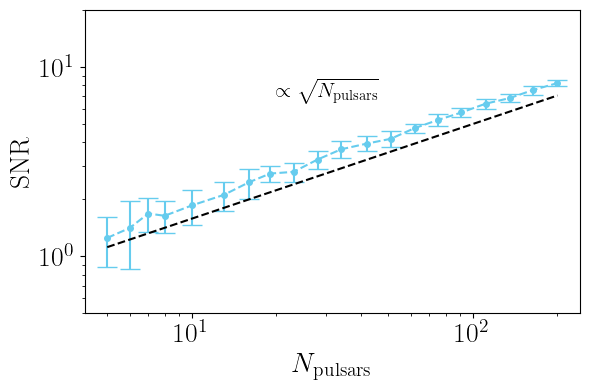

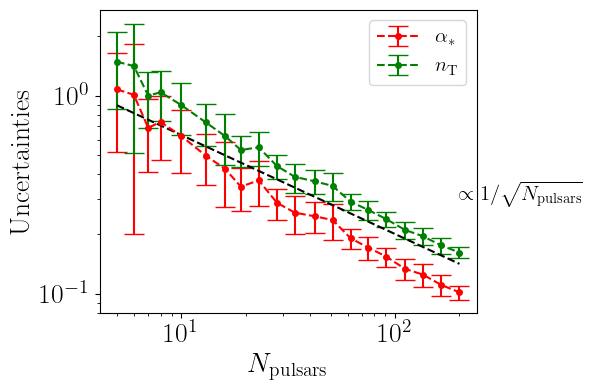

In [3]:
N_scaling()

Here starts N = 5


100%|██████████| 20/20 [00:00<00:00, 54.58it/s]


SNR=1.35e+00 +-4.89e-01 

Here starts N = 6


100%|██████████| 20/20 [00:00<00:00, 85.38it/s]


SNR=1.59e+00 +-3.66e-01 

Here starts N = 7


100%|██████████| 20/20 [00:00<00:00, 72.17it/s]


SNR=1.55e+00 +-2.78e-01 

Here starts N = 8


100%|██████████| 20/20 [00:00<00:00, 72.80it/s]


SNR=1.73e+00 +-3.84e-01 

Here starts N = 10


100%|██████████| 20/20 [00:00<00:00, 63.16it/s]


SNR=1.98e+00 +-3.30e-01 

Here starts N = 13


100%|██████████| 20/20 [00:00<00:00, 48.31it/s]


SNR=2.01e+00 +-3.86e-01 

Here starts N = 16


100%|██████████| 20/20 [00:00<00:00, 35.41it/s]


SNR=2.53e+00 +-3.44e-01 

Here starts N = 19


100%|██████████| 20/20 [00:00<00:00, 25.43it/s]


SNR=2.82e+00 +-3.74e-01 

Here starts N = 23


100%|██████████| 20/20 [00:00<00:00, 21.69it/s]


SNR=2.78e+00 +-3.21e-01 

Here starts N = 28


100%|██████████| 20/20 [00:01<00:00, 12.51it/s]


SNR=3.21e+00 +-3.19e-01 

Here starts N = 34


100%|██████████| 20/20 [00:00<00:00, 47.27it/s]


SNR=3.59e+00 +-3.64e-01 

Here starts N = 42


100%|██████████| 20/20 [00:00<00:00, 51.04it/s]


SNR=3.93e+00 +-4.09e-01 

Here starts N = 51


100%|██████████| 20/20 [00:00<00:00, 47.63it/s]


SNR=4.40e+00 +-3.41e-01 

Here starts N = 62


100%|██████████| 20/20 [00:00<00:00, 43.11it/s]


SNR=4.80e+00 +-4.45e-01 

Here starts N = 75


100%|██████████| 20/20 [00:00<00:00, 36.55it/s]


SNR=5.16e+00 +-2.62e-01 

Here starts N = 91


100%|██████████| 20/20 [00:00<00:00, 29.53it/s]


SNR=5.75e+00 +-2.99e-01 

Here starts N = 111


100%|██████████| 20/20 [00:02<00:00,  6.72it/s]


SNR=6.23e+00 +-3.87e-01 

Here starts N = 135


100%|██████████| 20/20 [00:03<00:00,  5.66it/s]


SNR=6.84e+00 +-3.01e-01 

Here starts N = 164


100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


SNR=7.63e+00 +-3.38e-01 

Here starts N = 200


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


SNR=8.09e+00 +-3.64e-01 



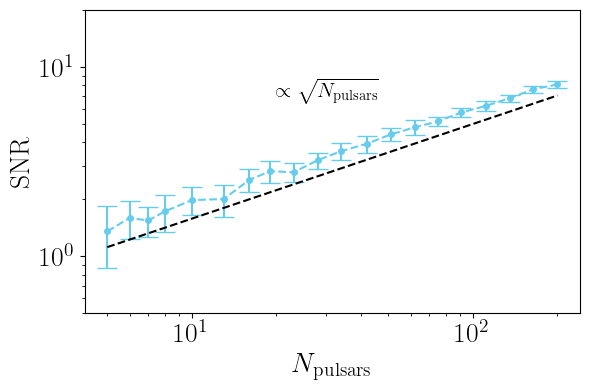

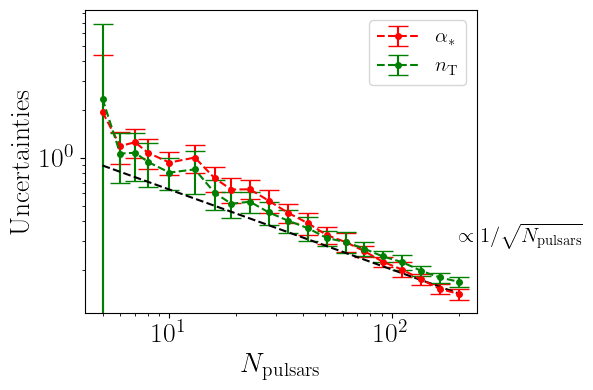

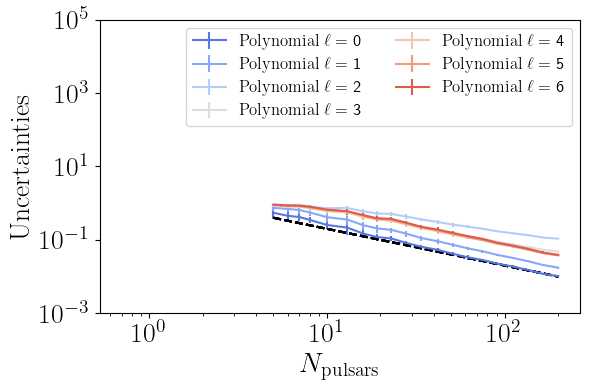

In [4]:
N_scaling(order=6)

Here starts T = 0.10 yrs (iteration 1 of 10)


100%|██████████| 20/20 [00:01<00:00, 14.28it/s]


SNR=5.36e-05 +-3.25e-05 

Here starts T = 0.28 yrs (iteration 2 of 10)


100%|██████████| 20/20 [00:00<00:00, 450.43it/s]


SNR=3.35e-03 +-3.24e-03 

Here starts T = 0.77 yrs (iteration 3 of 10)


100%|██████████| 20/20 [00:00<00:00, 454.54it/s]


SNR=4.64e-02 +-3.15e-02 

Here starts T = 2.15 yrs (iteration 4 of 10)


100%|██████████| 20/20 [00:01<00:00, 14.17it/s]


SNR=4.18e-01 +-1.10e-01 

Here starts T = 5.99 yrs (iteration 5 of 10)


100%|██████████| 20/20 [00:01<00:00, 13.57it/s]


SNR=1.94e+00 +-2.74e-01 

Here starts T = 16.68 yrs (iteration 6 of 10)


100%|██████████| 20/20 [00:01<00:00, 14.23it/s]


SNR=5.38e+00 +-4.69e-01 

Here starts T = 46.42 yrs (iteration 7 of 10)


100%|██████████| 20/20 [00:01<00:00, 14.01it/s]


SNR=1.20e+01 +-1.03e+00 

Here starts T = 129.15 yrs (iteration 8 of 10)


100%|██████████| 20/20 [00:01<00:00, 13.81it/s]


SNR=2.53e+01 +-1.58e+00 

Here starts T = 359.38 yrs (iteration 9 of 10)


100%|██████████| 20/20 [00:01<00:00, 12.71it/s]


SNR=4.73e+01 +-3.79e+00 

Here starts T = 1000.00 yrs (iteration 10 of 10)


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


SNR=9.10e+01 +-6.12e+00 



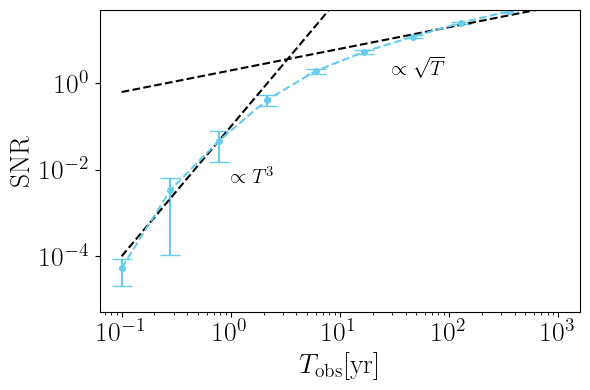

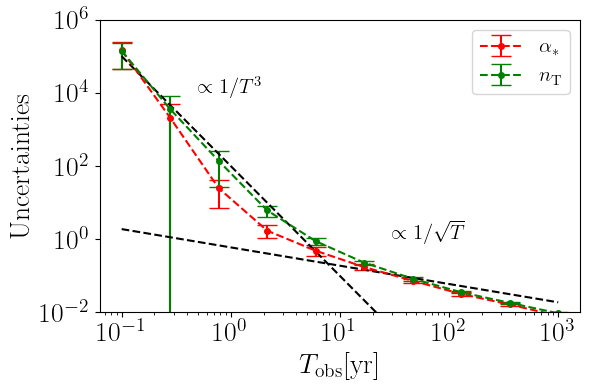

In [5]:
T_scaling(T_max_yrs=1e3)  # type: ignore